# 0. Load functions and set parameters

In [1]:
# %matplotlib notebook

import os, h5py, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import torch
from torch import nn
from scipy import signal
from scipy.optimize import curve_fit
from scipy.stats import zscore

sys.path.append('../')
from visualize_functions import show_images, plot_curve, show_grid_plots, label_violinplot
from analyze_spot_functions import NormalizeData
from fitting_functions import load_curve, load_multiple_curves, detect_peaks, analyze_curves, process_rheed_data
    
# from analyze_RHEED_spot_functions import show_metrics, Gaussian, generate_parameter_file, show_sound, show_fft_frequency, butter_filter, process_pass_filter
# from analyze_RHEED_intensity_functions import NormalizeData, trim_axes, show_images, show_plots
plt.rcParams.update(mpl.rcParamsDefault)

color_blue = (44/255,123/255,182/255)
color_green = (27/255,158/255,119/255)
color_orange = (217/255,95/255,2/255)
color_purple = (117/255,112/255,179/255)

rc_plot = {'figure.figsize':(12,2.5),
          'axes.facecolor':'white',
          'axes.grid': False,
          'axes.titlesize': 18,
          'axes.labelsize': 18,

          'xtick.labelsize': 14,
          'xtick.direction': 'in',
          'xtick.top': True,
          'xtick.bottom': True,
          'xtick.labelbottom': True,
          'xtick.labeltop': False,
          
          'ytick.labelsize': 14,
          'ytick.direction': 'in',
          'ytick.right': True,
          'ytick.left': True,
          'ytick.labelleft': True,
          'ytick.labelright': False,

          'legend.fontsize': 10,
          'font.family': 'sans-serif'}

rc_img = {'figure.figsize':(8,8),
          'axes.facecolor':'white',
          'axes.grid': False,
          'axes.titlesize': 18,
          'axes.labelsize': 14,
          
          'xtick.labelsize': 12,
          'xtick.direction': 'in',
          'xtick.top': False,
          'xtick.bottom': False,
          'xtick.labelbottom': False,
          'xtick.labeltop': False,
          
          'ytick.labelsize': 12,
          'ytick.direction': 'in',
          'ytick.right': False,
          'ytick.left': False,
          'ytick.labelleft': False,
          'ytick.labelright': False,

          'legend.fontsize': 8,
          'font.family': 'sans-serif'}

# 1. Visualize the spots from collected data

<KeysViewHDF5 ['background_with_heater', 'background_without_heater', 'growth_1.', 'growth_10', 'growth_11', 'growth_12', 'growth_2', 'growth_3', 'growth_4', 'growth_5', 'growth_6', 'growth_7', 'growth_8', 'growth_9']>


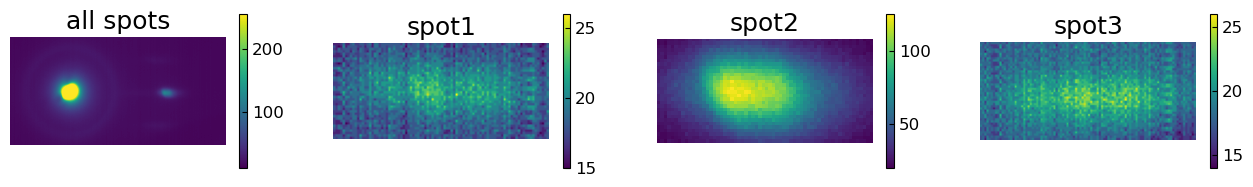

In [2]:
plt.rcParams.update(rc_img)

imgs = []
region = [(45, 85, 360, 450), (140, 170, 408, 470), (220, 265, 355, 455)]
with h5py.File('D:/datasets/RHEED_data/STO_STO_test7_06292022.h5', mode='r') as h5:
    print(h5.keys())
    spots_name = ['spot1', 'spot2', 'spot3']
    img_all_spots = np.array(h5['growth_2'][20])
    plt.imsave('../figures/1.test7_all_spots.png', img_all_spots)
    
    imgs.append(img_all_spots)
    for i, sn in enumerate(spots_name):
        imgs.append(NormalizeData(img_all_spots[region[i][0]:region[i][1], region[i][2]:region[i][3]]).astype(np.float32))
        plt.imsave('../figures/1.test7_'+sn+'.png', imgs[i+1])

show_images(imgs, ['all spots']+spots_name, img_per_row=4, img_height=0.1, colorbar=True)

In [43]:
def two_color_array(x_all, x1, x2, c1, c2, transparency=1):
    color_array = np.zeros([len(x_all), 4], dtype=np.float32)
    color_array[np.isin(x_all, x1)] = [*c1, transparency]
    color_array[np.isin(x_all, x2)] = [*c2, transparency]
    return color_array

def plot_bg(colors_all, save_path=None):
    fig, ax = plt.subplots()
    ax.imshow([colors_all], aspect='auto')
    ax.axis('off')
    if save_path: 
        plt.savefig(save_path)
    plt.show()

# 2. Visualize RHEED intensity oscillation

## 2.1 Treated substrate(step width=0.43±0.04μm) - Raw data

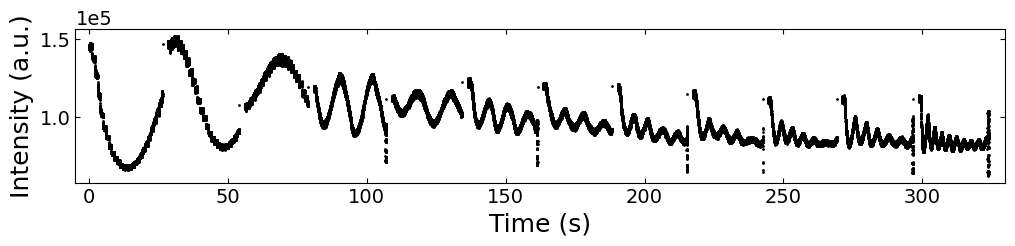

In [3]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3, 'growth_6':5, 
               'growth_7':5, 'growth_8':7, 'growth_9':7, 'growth_10':9, 'growth_11':9, 'growth_12':15}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=1000)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2), xlim=[-5,330],
           markersize=1, save_path='../figures/3.sample1_intensity.png')

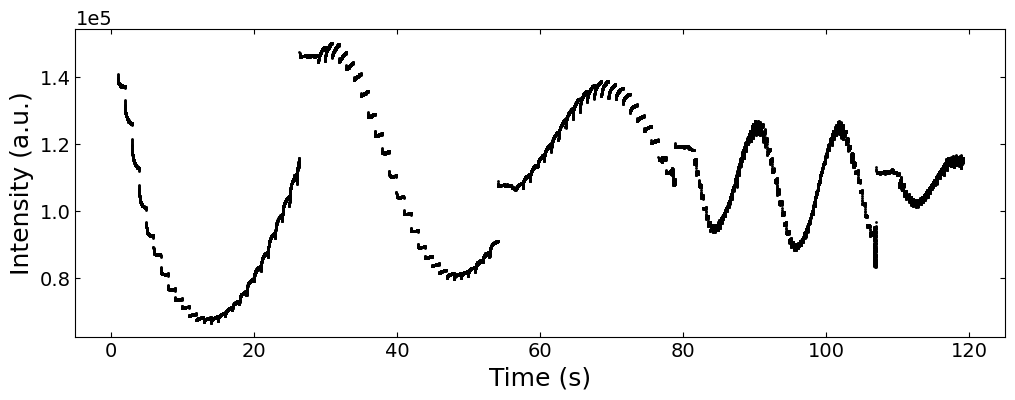

In [41]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3, }
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=1000)
x_sample = x_all[x_all<120]
y_sample = y_all[x_all<120]

x_peaks, xs, ys = detect_peaks(x_sample, y_sample, camera_freq=500, laser_freq=1, step_size=5, prominence=0.1)
xs, ys = process_rheed_data(xs, ys, length=500, savgol_window_order=(15, 3), pca_component=10)

x_sample, y_sample = np.concatenate(xs), np.concatenate(ys)
plot_curve(x_sample, y_sample, plot_type='scatter', xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,4))

In [ ]:
plt.scatter()

In [52]:
def plot_bg(colors_all, x1, y1, x2, y2, save_path=None):
    fig, ax = plt.subplots()
    ax.scatter(x1, y1, s=1)
    ax.scatter(x2, y2, s=1)
    ax.imshow([colors_all], aspect='auto')
    ax.axis('off')
    if save_path: 
        plt.savefig(save_path)
    plt.show()

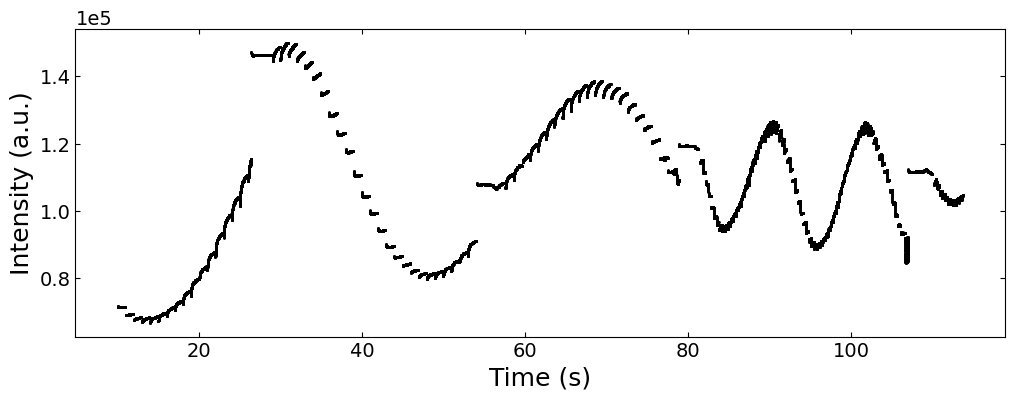

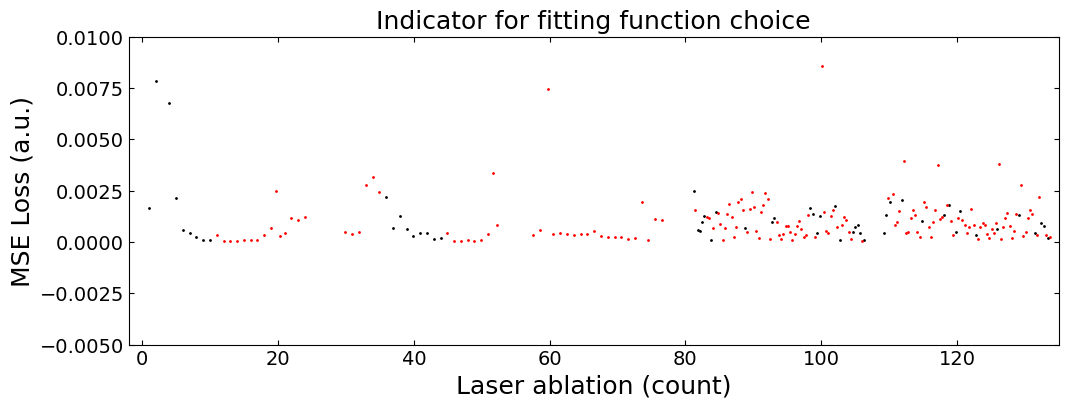

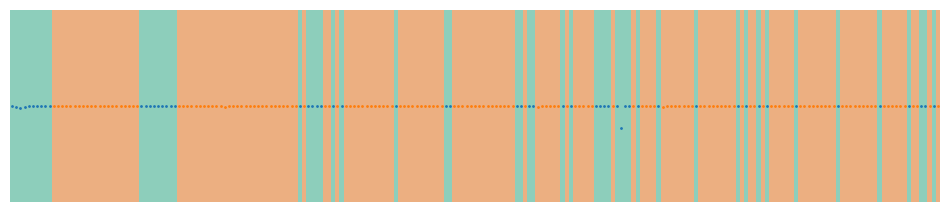

In [85]:
plt.rcParams.update(rc_plot)
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
visualize = False
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, spot, metric, x_start=0, interval=interval)
x_peaks, xs, ys = detect_peaks(x_sample, y_sample, camera_freq=500, laser_freq=1, step_size=5, prominence=0.1)
xs, ys = process_rheed_data(xs, ys, length=500, savgol_window_order=(15, 3), pca_component=10)
x_sample, y_sample = np.concatenate(xs), np.concatenate(ys)
plot_curve(x_sample, y_sample, plot_type='scatter', xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,4))


parameters_all, x_coor_all, info = analyze_curves(h5_para_file, growth_dict, spot, metric, camera_freq=camera_freq, 
                                                  interval=interval,  visualize=visualize, fit_settings=fit_settings)
[xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, labels_all, losses_all] = info

x_y1 = x_coor_all[losses_all[:,0]>losses_all[:,1]]
x_y2 = x_coor_all[losses_all[:,0]<losses_all[:,1]]
loss_y1 = losses_all[:,0][losses_all[:,0]>losses_all[:,1]]
loss_y2 = losses_all[:,1][losses_all[:,0]<losses_all[:,1]]
plot_curve(x_y1, loss_y1, curve_x_fit=x_y2, curve_y_fit=loss_y2, plot_type='scatter', xlim=(-2, 135), 
           ylim=(-0.005, 0.01), xlabel='Laser ablation (count)', ylabel='MSE Loss (a.u.)', yaxis_style='linear', 
           figsize=(12, 4), title='Indicator for fitting function choice')

order = x_coor_all.argsort()
x_y1_index = np.where(np.isin(x_coor_all, x_y1))[0]
x_y2_index = np.where(np.isin(x_coor_all, x_y2))[0]
color_array = two_color_array(x_coor_all, x_y1, x_y2, color_green, color_orange, transparency=0.5)

plot_bg(color_array, x_y1_index, loss_y1, x_y2_index, loss_y2)

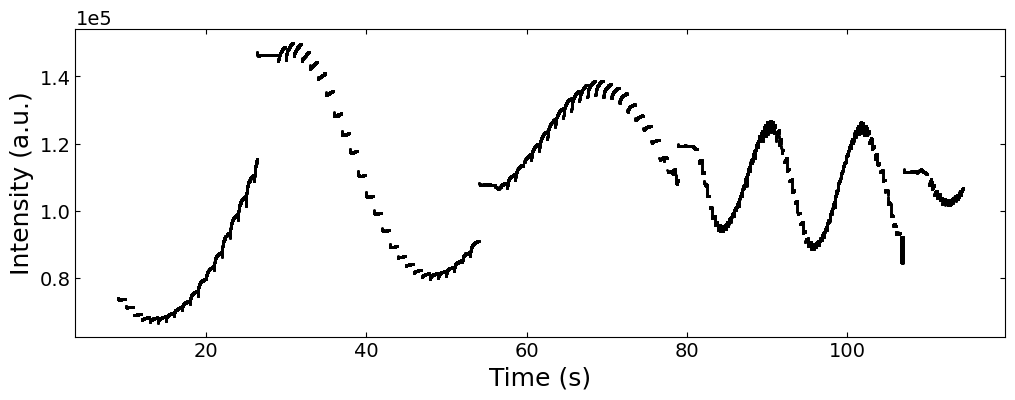

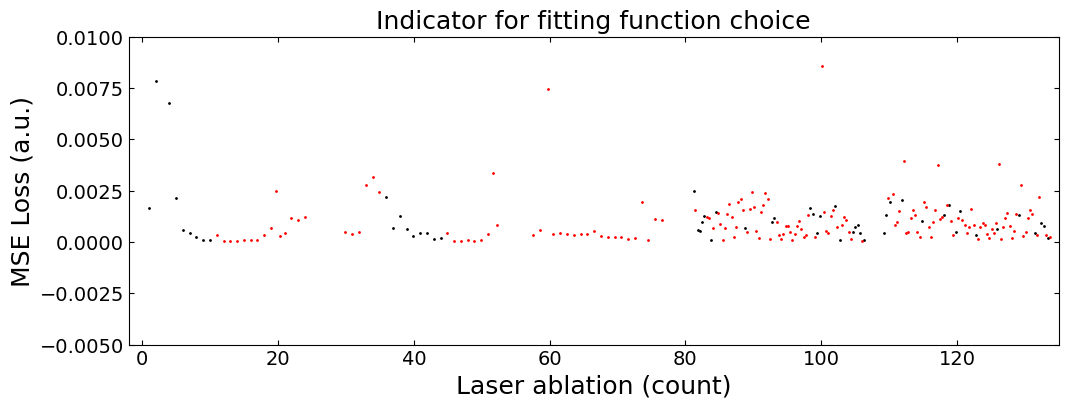

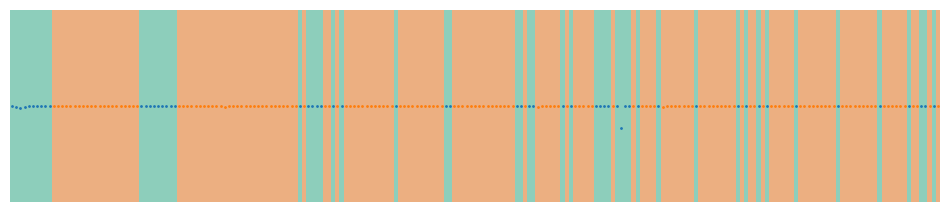

In [69]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plt.scatter(x=x_sample, y=y_sample, c='k', s=markersize)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useLocale=False)    
plt.show()

In [82]:
color_array[5:30]

array([[0.10588235, 0.61960787, 0.46666667, 0.5       ],
       [0.10588235, 0.61960787, 0.46666667, 0.5       ],
       [0.10588235, 0.61960787, 0.46666667, 0.5       ],
       [0.10588235, 0.61960787, 0.46666667, 0.5       ],
       [0.10588235, 0.61960787, 0.46666667, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903,

In [79]:
x_coor_all[10:20]

array([10.958, 11.958, 12.96 , 13.958, 14.958, 15.958, 16.956, 17.958,
       18.956, 19.642])

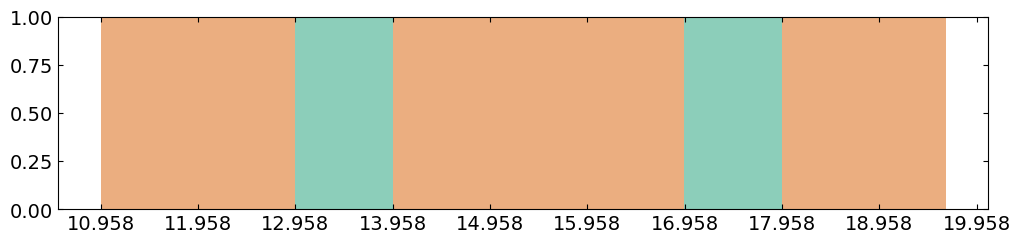

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Sample X coordinates
x = np.array([10.958, 11.958, 12.96, 13.958, 14.958, 15.958, 16.956, 17.958, 18.956, 19.642])

# Sample colors
colors = np.array([[0.8509804, 0.37254903, 0.00784314, 0.5],
                   [0.8509804, 0.37254903, 0.00784314, 0.5],
                   [0.10588235, 0.61960787, 0.46666667, 0.5],
                   [0.8509804, 0.37254903, 0.00784314, 0.5],
                   [0.8509804, 0.37254903, 0.00784314, 0.5],
                   [0.8509804, 0.37254903, 0.00784314, 0.5],
                   [0.10588235, 0.61960787, 0.46666667, 0.5],
                   [0.8509804, 0.37254903, 0.00784314, 0.5],
                   [0.8509804, 0.37254903, 0.00784314, 0.5],
                   [0.8509804, 0.37254903, 0.00784314, 0.5]])

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the color blocks
for i in range(len(x) - 1):
    ax.axvspan(x[i], x[i + 1], facecolor=colors[i][:3], alpha=colors[i][3])

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# Show the plot
plt.show()

In [93]:
color_array.shape

(223, 4)

In [96]:
np.sum(color_array[:,:3], axis=1)

array([1.1921569, 1.1921569, 1.1921569, 1.1921569, 1.1921569, 1.1921569,
       1.1921569, 1.1921569, 1.1921569, 1.1921569, 1.2313726, 1.2313726,
       1.2313726, 1.2313726, 1.2313726, 1.2313726, 1.2313726, 1.2313726,
       1.2313726, 1.2313726, 1.2313726, 1.2313726, 1.2313726, 1.2313726,
       1.2313726, 1.2313726, 1.2313726, 1.2313726, 1.2313726, 1.2313726,
       1.2313726, 1.1921569, 1.1921569, 1.1921569, 1.1921569, 1.1921569,
       1.1921569, 1.1921569, 1.1921569, 1.1921569, 1.2313726, 1.2313726,
       1.2313726, 1.2313726, 1.2313726, 1.2313726, 1.2313726, 1.2313726,
       1.2313726, 1.2313726, 1.2313726, 1.2313726, 1.2313726, 1.2313726,
       1.2313726, 1.2313726, 1.2313726, 1.2313726, 1.2313726, 1.2313726,
       1.2313726, 1.2313726, 1.2313726, 1.2313726, 1.2313726, 1.2313726,
       1.2313726, 1.2313726, 1.2313726, 1.1921569, 1.2313726, 1.1921569,
       1.1921569, 1.1921569, 1.1921569, 1.2313726, 1.2313726, 1.1921569,
       1.2313726, 1.1921569, 1.2313726, 1.2313726, 

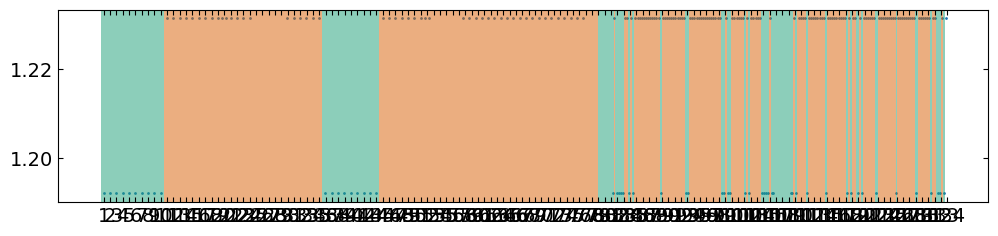

In [108]:
plot_bg_X(color_array, x_coor_all, save_path=None)

In [176]:
def plot_curve(curve_x, curve_y, curve_x_fit=None, curve_y_fit=None, labels_dict=None, bg_colors=None, plot_type='scatter', markersize=1, xlabel=None, ylabel=None, xlim=None, ylim=None,  yaxis_style='sci', title=None, legend=None, figsize=(12,2.5), save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    if type(bg_colors) != type(None):
        x_coor = bg_colors[:,0]
        colors = bg_colors[:,1:]

        for i in range(len(x_coor)):
            if i == 0: 
                end = (x_coor[i] + x_coor[i+1]) / 2
                start = end - (x_coor[i+1] - x_coor[i])
            elif i == len(x_coor) - 1: 
                start = (x_coor[i-1] + x_coor[i]) / 2
                end = start + (x_coor[i] - x_coor[i-1])
            else:
                start = (x_coor[i-1] + x_coor[i]) / 2
                end = (x_coor[i] + x_coor[i+1]) / 2
            ax.axvspan(start, end, facecolor=colors[i])
            
    
    if plot_type == 'scatter':
        plt.scatter(x=curve_x, y=curve_y, c='k', s=markersize)
        if type(curve_y_fit) != type(None):
            if type(curve_x_fit) != type(None):
                plt.scatter(x=curve_x_fit, y=curve_y_fit, c='r', s=markersize)
            else:
                plt.scatter(x=curve_x, y=curve_y_fit, c='r', s=markersize)

    if plot_type == 'lineplot':
        plt.plot(curve_x, curve_y, color='k', marker='.', markersize=markersize)
        if type(curve_y_fit) != type(None):
            if type(curve_x_fit) != type(None):
                plt.plot(curve_x_fit, curve_y_fit, color='b', marker='.', markersize=markersize)
            else:
                plt.plot(curve_x, curve_y_fit, color='b', marker='.', markersize=markersize)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if type(xlim) != type(None): ax.set_xlim(xlim)
    if type(ylim) != type(None): ax.set_ylim(ylim)
    if yaxis_style == 'sci':
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useLocale=False)    
    if type(labels_dict) != type(None):
        for x in labels_dict.keys():
            y = curve_y[np.where(curve_x==find_nearest(curve_x, x))]
            pl.text(x, y, str(labels_dict[x]), color="g", fontsize=6)
            
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    if legend: plt.legend(legend)
    plt.show()


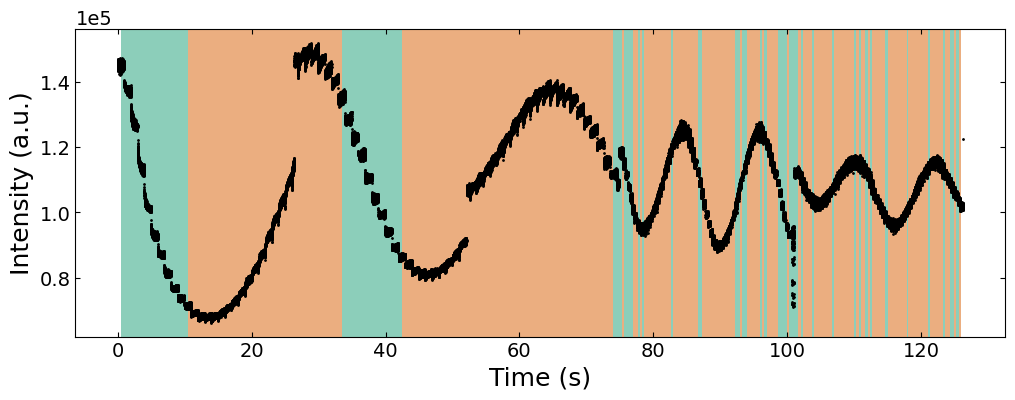

In [179]:
plt.rcParams.update(rc_plot)
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
visualize = False
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, spot, metric, x_start=0, interval=0)
parameters_all, x_coor_all, info = analyze_curves(h5_para_file, growth_dict, spot, metric, camera_freq=camera_freq, 
                                                  interval=0,  visualize=visualize, fit_settings=fit_settings)
[xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, labels_all, losses_all] = info
x_y1 = x_coor_all[losses_all[:,0]>losses_all[:,1]]
x_y2 = x_coor_all[losses_all[:,0]<losses_all[:,1]]
color_array = two_color_array(x_coor_all, x_y1, x_y2, color_green, color_orange, transparency=0.5)

color_array = np.concatenate([np.expand_dims(x_coor_all, 1), color_array], axis=1)
plot_curve(x_all, y_all, plot_type='scatter', xlabel='Time (s)', ylabel='Intensity (a.u.)', bg_colors=color_array, 
           figsize=(12,4))

In [171]:
def plot_bg_X(x, colors, x_sample, y_sample, save_path=None):
    
    fig, ax = plt.subplots()
#     ax.scatter(x, np.sum(color_array[:,:3], axis=1), s=1)
    
    for i in range(len(x)):
        if i == 0: 
            end = (x[i] + x[i+1]) / 2
            start = end - (x[i+1] - x[i])
        elif i == len(x) - 1: 
            start = (x[i-1] + x[i]) / 2
            end = start + (x[i] - x[i-1])
        else:
            start = (x[i-1] + x[i]) / 2
            end = (x[i] + x[i+1]) / 2

        ax.axvspan(start, end, facecolor=colors[i])
        
    plt.scatter(x=x_sample, y=y_sample, c='k')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useLocale=False)  
    # ax.axis('off')
    if save_path: 
        plt.savefig(save_path)
    plt.show()

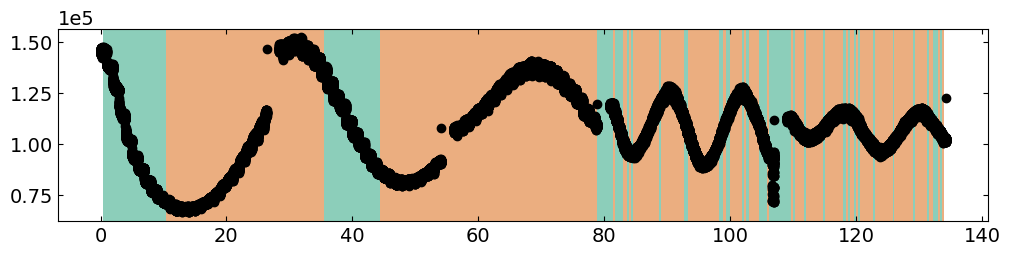

In [172]:
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, spot, metric, x_start=0, interval=interval)
x_peaks, xs, ys = detect_peaks(x_sample, y_sample, camera_freq=500, laser_freq=1, step_size=5, prominence=0.1)
xs, ys = process_rheed_data(xs, ys, length=500, savgol_window_order=(15, 3), pca_component=10)
x_sample, y_sample = np.concatenate(xs), np.concatenate(ys)

plot_bg_X(x_coor_all, color_array, x_all, y_all, save_path=None)

In [162]:
color_array

array([[0.10588235, 0.61960787, 0.46666667, 0.5       ],
       [0.10588235, 0.61960787, 0.46666667, 0.5       ],
       [0.10588235, 0.61960787, 0.46666667, 0.5       ],
       [0.10588235, 0.61960787, 0.46666667, 0.5       ],
       [0.10588235, 0.61960787, 0.46666667, 0.5       ],
       [0.10588235, 0.61960787, 0.46666667, 0.5       ],
       [0.10588235, 0.61960787, 0.46666667, 0.5       ],
       [0.10588235, 0.61960787, 0.46666667, 0.5       ],
       [0.10588235, 0.61960787, 0.46666667, 0.5       ],
       [0.10588235, 0.61960787, 0.46666667, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903, 0.00784314, 0.5       ],
       [0.8509804 , 0.37254903,

In [156]:
x_sample

array([  9.968     ,   9.9698084 ,   9.9716168 , ..., 113.73731569,
       113.7391131 , 113.74091052])

In [157]:
x_sample.shape

(61500,)

In [158]:
x_all.shape

(63125,)

In [159]:
x_all

array([0.00000e+00, 2.00000e-03, 4.00000e-03, ..., 1.34244e+02,
       1.34246e+02, 1.34248e+02])

In [145]:
color = np.array([[0.1, 0.4, 0.8, 0.5],
                  [0.2, 0.2, 0.2, 0.5],
                  [0.1, 0.4, 0.8, 0.5],
                  [0.1, 0.4, 0.8, 0.5],
                  [0.4, 0.6, 0.6, 0.5],
                  [0.1, 0.4, 0.8, 0.5],
                  [0.4, 0.4, 0.8, 0.5],
                  [0.1, 0.4, 0.8, 0.5],
                  [0.4, 0.6, 0.6, 0.5],
                  [0.1, 0.4, 0.8, 0.5]], dtype=np.float32)

x = np.array([10.958, 11.958, 12.96, 13.958, 14.958, 15.958, 16.956, 17.958, 18.956, 19.956], dtype=np.float32)

start
10.458000183105469 11.458000183105469 1.0
11.458000183105469 12.458999633789062 1.0009994506835938
12.458999633789062 13.458999633789062 1.0
13.458999633789062 14.458000183105469 0.9990005493164062
14.458000183105469 15.458000183105469 1.0
15.458000183105469 16.457000732421875 0.9990005493164062
16.457000732421875 17.457000732421875 1.0
17.457000732421875 18.457000732421875 1.0
18.457000732421875 19.45599937438965 0.9989986419677734
end
19.45599937438965 20.45599937438965 1.0


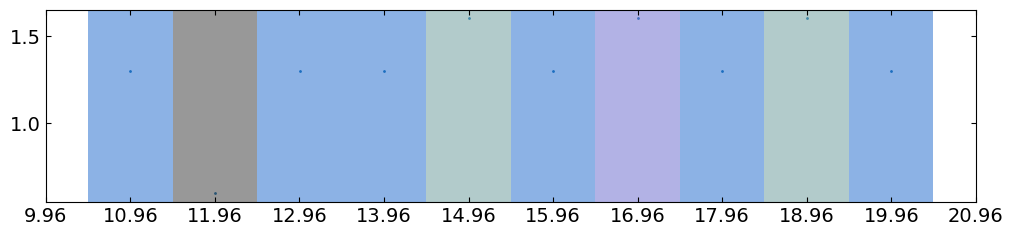

In [146]:
plot_bg_X(color, x, save_path=None)

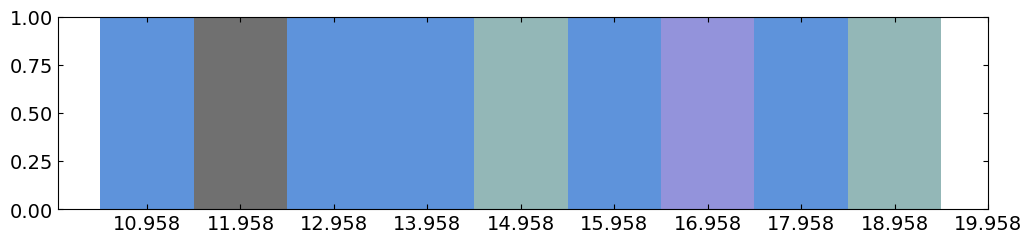

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
color = np.array([[0.1, 0.4, 0.8, 0.5],
                  [0.2, 0.2, 0.2, 0.5],
                  [0.1, 0.4, 0.8, 0.5],
                  [0.1, 0.4, 0.8, 0.5],
                  [0.4, 0.6, 0.6, 0.5],
                  [0.1, 0.4, 0.8, 0.5],
                  [0.4, 0.4, 0.8, 0.5],
                  [0.1, 0.4, 0.8, 0.5],
                  [0.4, 0.6, 0.6, 0.5],
                  [0.1, 0.4, 0.8, 0.5]], dtype=np.float32)

x = np.array([10.958, 11.958, 12.96, 13.958, 14.958, 15.958, 16.956, 17.958, 18.956, 19.642], dtype=np.float32)

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the color blocks
for i in range(len(x) - 1):
    if i == 0: 
        start = x[i] - ((x[i] + x[i+1]) / 2 - x[i])
        end = (x[i] + x[i+1]) / 2

    elif i == len(x) - 2: 
        start = (x[i-1] + x[i]) / 2
        end = x[i] + ((x[i] + x[i-1]) / 2 - x[i-1])
        
    else:
        start = (x[i-1] + x[i]) / 2
        end = (x[i] + x[i+1]) / 2
    
    # Get the color for the block
    block_color = color[i]
    # Plot the block
    ax.axvspan(start, end, facecolor=block_color, alpha=0.7)

# Set the x-limits of the plot
# ax.set_xlim(x[0], x[-1])
plt.xticks(np.arange(min(x), max(x)+1, 1.0))

# Show the plot
plt.show()


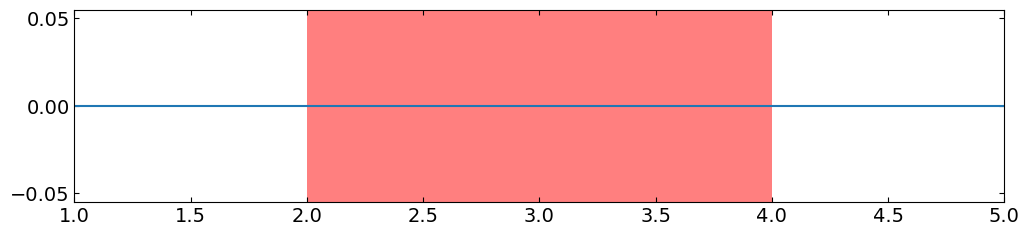

In [70]:
import matplotlib.pyplot as plt

# Sample x-coordinates
x = [1, 2, 3, 4, 5]

# Define the x-limits of the color block
xmin = 2
xmax = 4

# Define the color of the block (here we use red)
color = 'r'

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the color block
ax.axvspan(xmin, xmax, facecolor=color, alpha=0.5)

# Plot the x-coordinates
ax.plot(x, [0]*len(x))

# Set the x-limits of the plot
ax.set_xlim(min(x), max(x))

# Show the plot
plt.show()

In [25]:
def plot_transparent_bg(colors_all, save_path=None):
    fig, ax = plt.subplots()
    ax.imshow([colors_all], aspect='auto')
    ax.axis('off')
    if save_path: 
        plt.savefig(save_path)
    plt.show()

In [6]:
spot = 'spot_2'
metric = 'img_intensity'
interval = 1000
camera_freq = 500
fit_settings = {'savgol_window_order': (15, 3), 'pca_component': 10, 'I_diff': 15000, 
                'unify':False, 'bounds':[0.001, 1], 'p_init':[0.1, 0.4, 0.1]}

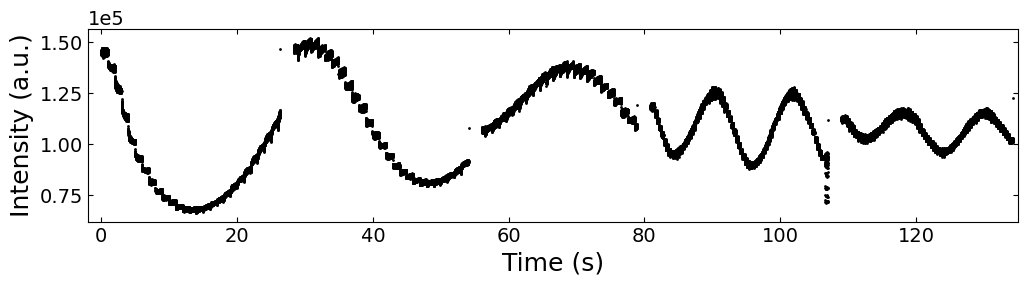

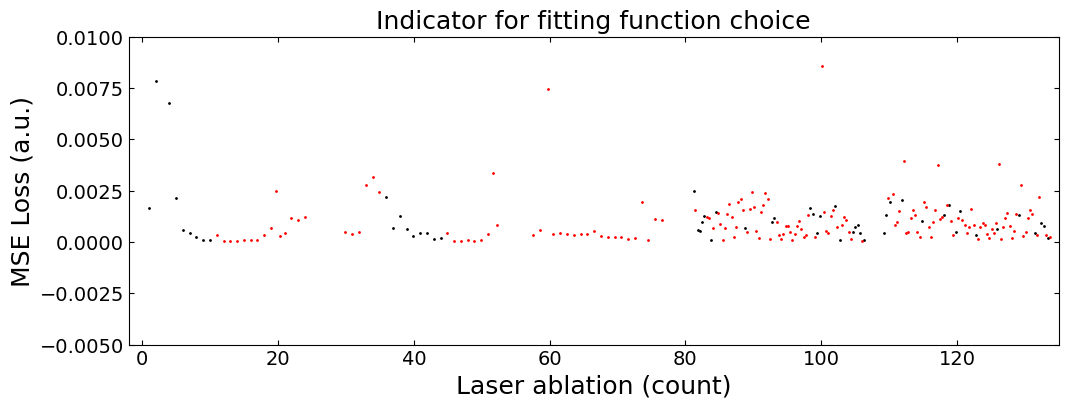

In [7]:
plt.rcParams.update(rc_plot)
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
visualize = False
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, spot, metric, x_start=0, interval=interval)

parameters_all, x_coor_all, info = analyze_curves(h5_para_file, growth_dict, spot, metric, camera_freq=camera_freq, 
                                                  interval=interval,  visualize=visualize, fit_settings=fit_settings)
[xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, labels_all, losses_all] = info

plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2.5), xlim=(-2, 135), 
           save_path='../figures/test6_intensity.png')

x_y1 = x_coor_all[losses_all[:,0]>losses_all[:,1]]
loss_y1 = losses_all[:,0][losses_all[:,0]>losses_all[:,1]]
x_y2 = x_coor_all[losses_all[:,0]<losses_all[:,1]]
loss_y2 = losses_all[:,1][losses_all[:,0]<losses_all[:,1]]
plot_curve(x_y1, loss_y1, curve_x_fit=x_y2, curve_y_fit=loss_y2, plot_type='scatter', xlim=(-2, 135), 
           ylim=(-0.005, 0.01), xlabel='Laser ablation (count)', ylabel='MSE Loss (a.u.)', yaxis_style='linear', 
           figsize=(12, 4), title='Indicator for fitting function choice', save_path='../figures/test6_indicator.svg')

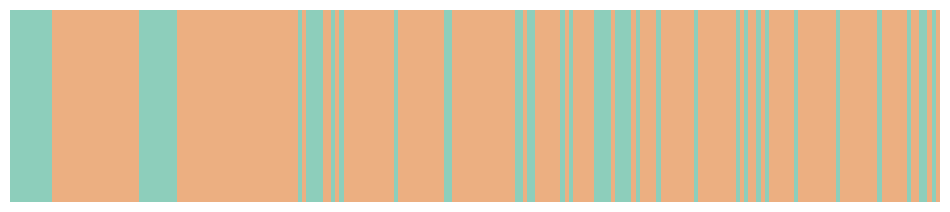

In [40]:
color_array = two_color_array(x_coor_all, x_y1, x_y2, color_green, color_orange, transparency=0.5)
plot_bg(color_array)

[[0.10588235 0.61960787 0.46666667 0.5       ]
 [0.10588235 0.61960787 0.46666667 0.5       ]
 [0.10588235 0.61960787 0.46666667 0.5       ]
 [0.10588235 0.61960787 0.46666667 0.5       ]
 [0.10588235 0.61960787 0.46666667 0.5       ]
 [0.10588235 0.61960787 0.46666667 0.5       ]
 [0.10588235 0.61960787 0.46666667 0.5       ]
 [0.10588235 0.61960787 0.46666667 0.5       ]
 [0.10588235 0.61960787 0.46666667 0.5       ]
 [0.10588235 0.61960787 0.46666667 0.5       ]
 [0.8509804  0.37254903 0.00784314 0.5       ]
 [0.8509804  0.37254903 0.00784314 0.5       ]
 [0.8509804  0.37254903 0.00784314 0.5       ]
 [0.8509804  0.37254903 0.00784314 0.5       ]
 [0.8509804  0.37254903 0.00784314 0.5       ]
 [0.8509804  0.37254903 0.00784314 0.5       ]
 [0.8509804  0.37254903 0.00784314 0.5       ]
 [0.8509804  0.37254903 0.00784314 0.5       ]
 [0.8509804  0.37254903 0.00784314 0.5       ]
 [0.8509804  0.37254903 0.00784314 0.5       ]
 [0.8509804  0.37254903 0.00784314 0.5       ]
 [0.8509804  

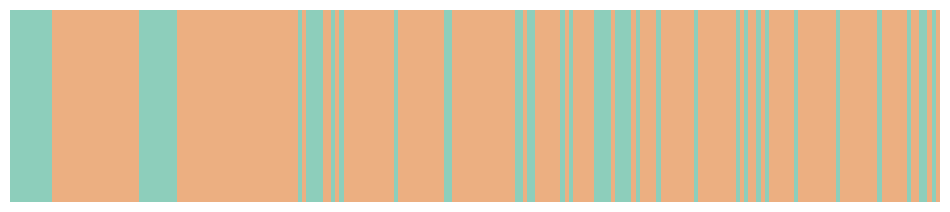

In [36]:
import numpy as np

A = x_coor_all
B = x_y1
C = x_y2

color_array = np.zeros([len(A), 4], dtype=np.float32)

# Assign (27/255,158/255,119/255) to values in B
color_array[np.isin(A, B)] = [27/255, 158/255, 119/255, 0.5]

# Assign (217/255,95/255,2/255) to values in C
color_array[np.isin(A, C)] = [217/255, 95/255, 2/255, 0.5]

print(color_array)

def plot_bg(colors_all, save_path=None):
    fig, ax = plt.subplots()
    ax.imshow([colors_all], aspect='auto')
    ax.axis('off')
    if save_path: 
        plt.savefig(save_path)
    plt.show()

plot_bg(color_array)

In [19]:
loss_y1, loss_y2

(array([1.65774825e-03, 7.83980166e-03, 1.20850481e-02, 6.76160403e-03,
        2.11474706e-03, 5.99789898e-04, 4.17816028e-04, 2.48400856e-04,
        1.12504849e-04, 7.15377641e-05, 2.19306378e-03, 6.79169835e-04,
        1.27878727e-03, 6.45168590e-04, 2.69528288e-04, 4.23428198e-04,
        4.12445708e-04, 1.55227311e-04, 2.14783122e-04, 2.49719054e-03,
        5.73799819e-04, 5.08640410e-04, 9.87234061e-04, 1.24395360e-03,
        9.02957464e-05, 1.43834893e-03, 6.72858088e-04, 9.81247676e-04,
        1.14770302e-03, 1.66155956e-03, 1.34314538e-03, 4.36274900e-04,
        1.28410297e-03, 1.73138789e-03, 1.10528492e-04, 4.75324511e-04,
        7.34158890e-04, 8.30917312e-04, 4.11454907e-04, 1.00334154e-04,
        1.14645647e-01, 4.15791394e-04, 1.32349332e-03, 1.96097538e-03,
        2.04375762e-03, 1.00774973e-03, 1.33362267e-03, 1.77969386e-03,
        5.04039320e-04, 1.48525537e-03, 3.22133062e-04, 6.43936974e-04,
        1.30630530e-03, 4.26501070e-04, 9.31281670e-04, 7.899057

In [ ]:
color_green = (27/255,158/255,119/255)
color_orange = (217/255,95/255,2/255)

In [ ]:
for x in x_sample:
    

In [20]:
x_sample

array([  0.968     ,   0.96997996,   0.97195992, ..., 119.13737074,
       119.13868537, 119.14      ])

In [24]:
import numpy as np

A = np.array([0, 1, 2, 3, 4, 5, 6])
B = np.array([1, 3, 5, 6])
C = np.array([0, 2, 4])

color_array = np.zeros([len(A), 3], dtype=np.float32)

# Assign (27/255,158/255,119/255) to values in B
color_array[np.isin(A, B)] = [27/255, 158/255, 119/255]

# Assign (217/255,95/255,2/255) to values in C
color_array[np.isin(A, C)] = [217/255, 95/255, 2/255]

print(color_array)

[[0.8509804  0.37254903 0.00784314]
 [0.10588235 0.61960787 0.46666667]
 [0.8509804  0.37254903 0.00784314]
 [0.10588235 0.61960787 0.46666667]
 [0.8509804  0.37254903 0.00784314]
 [0.10588235 0.61960787 0.46666667]
 [0.10588235 0.61960787 0.46666667]]


In [27]:
def plot_bg(colors_all, save_path=None):
    fig, ax = plt.subplots()
    ax.imshow([colors_all], aspect='auto')
    ax.axis('off')
    if save_path: 
        plt.savefig(save_path)
    plt.show()

plot_bg(color_array)

In [ ]:
tau_test6_clean

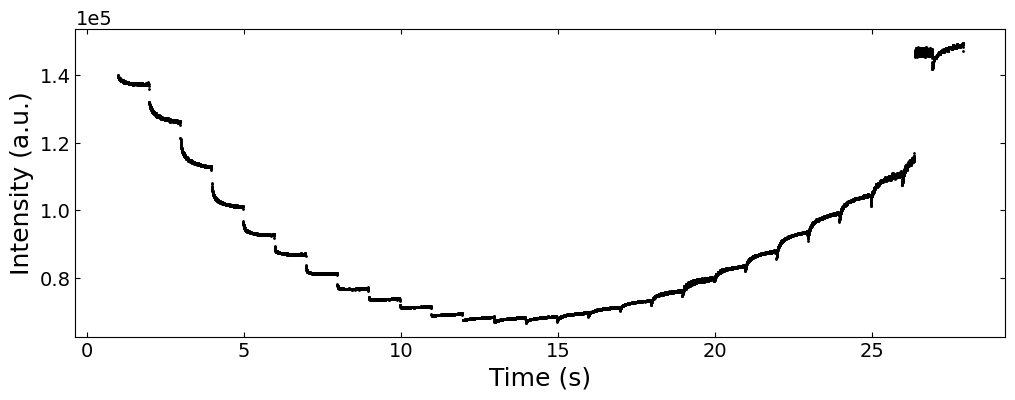

In [62]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=0)
x_sample = x_all[x_all<29]
y_sample = y_all[x_all<29]

x_peaks, xs, ys = detect_peaks(x_sample, y_sample, camera_freq=500, laser_freq=1, step_size=5, prominence=0.1)
xs, ys = process_rheed_data(xs, ys, length=500, savgol_window_order=(15, 3), pca_component=10)

x_sample, y_sample = np.concatenate(xs), np.concatenate(ys)
plot_curve(x_sample, y_sample, plot_type='scatter', xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,4), 
          save_path='../figures/3.Test6-First_unit_cell.png')

In [ ]:
plt.rcParams.update(rc_plot)
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
# growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1}
# growth_dict = {'growth_4':3, 'growth_5':3}
h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
visualize = False
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, spot, metric, x_start=0, interval=interval)

parameters_all, x_coor_all, info = analyze_curves(h5_para_file, growth_dict, spot, metric, camera_freq=camera_freq, 
                                                  interval=interval,  visualize=visualize, fit_settings=fit_settings)
[xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, labels_all, losses_all] = info

plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2.5), xlim=(-2, 135), 
           save_path='../figures/test6_intensity.png')

x_y1 = x_coor_all[losses_all[:,0]>losses_all[:,1]]
loss_y1 = losses_all[:,0][losses_all[:,0]>losses_all[:,1]]
x_y2 = x_coor_all[losses_all[:,0]<losses_all[:,1]]
loss_y2 = losses_all[:,1][losses_all[:,0]<losses_all[:,1]]
plot_curve(x_y1, loss_y1, curve_x_fit=x_y2, curve_y_fit=loss_y2, plot_type='scatter', xlim=(-2, 135), 
           ylim=(-0.005, 0.01), xlabel='Laser ablation (count)', ylabel='MSE Loss (a.u.)', yaxis_style='linear', 
           figsize=(12, 4), title='Indicator for fitting function choice', save_path='../figures/test6_indicator.svg')

plot_curve(x_coor_all, parameters_all[:,0], plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude Constant (a.u.)', 
           yaxis_style='linear', figsize=(12, 4), xlim=(-2, 135), save_path='../figures/test6_a_raw.svg')
plot_curve(x_coor_all, parameters_all[:,1], plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='Intensity Magnitude Linear (a.u.)', 
           yaxis_style='linear', figsize=(12, 4), xlim=(-2, 135), save_path='../figures/test6_b_raw.svg')
plot_curve(x_coor_all, parameters_all[:,2], plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='Characteristic Time (s)', 
           yaxis_style='linear', figsize=(12, 4), xlim=(-2, 135), save_path='../figures/test6_tau_raw.svg')

x_coor_all_clean, tau_test6_clean = remove_outlier(x_coor_all, parameters_all[:,2], 0.9)
tau_test6_clean = smooth(tau_test6_clean, 5)
plot_curve(x_coor_all_clean, tau_test6_clean, plot_type='lineplot', xlabel='Laser ablation (count)', 
           ylabel='Characteristic Time (fine-tuned) (s)', yaxis_style='linear', figsize=(12, 4), xlim=(-2, 135), 
           save_path='../figures/test6_tau.svg')
print('MSE loss for classic fitting is:', nn.MSELoss()(torch.tensor(np.concatenate(ys_nor_all, 0)), torch.tensor(np.concatenate(ys_nor_fit_all, 0))).item())

x_coor_all = np.expand_dims(x_coor_all, 1)
np.save('../saved_data/test6_fitting_results(sklearn).npy', np.concatenate([x_coor_all, parameters_all], axis=1))

## 2.2 Treated substrate(step width=0.11±0.01μm)

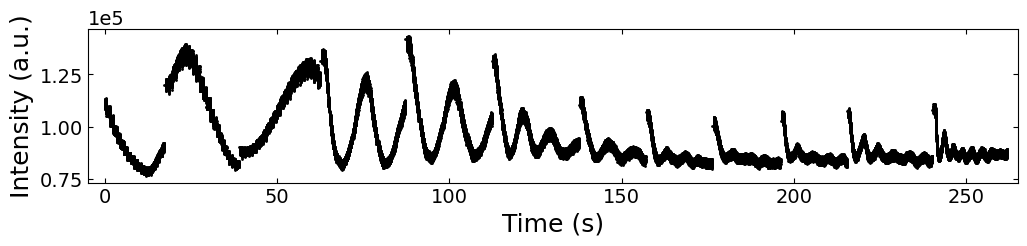

In [6]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test7_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3, 
               'growth_6':5, 'growth_7':5, 'growth_8':7, 'growth_9':7, 'growth_10':9, 
               'growth_11':9, 'growth_12':15}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=200)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2), xlim=[-5,265],
           save_path='../figures/3.sample2_intensity.png')           

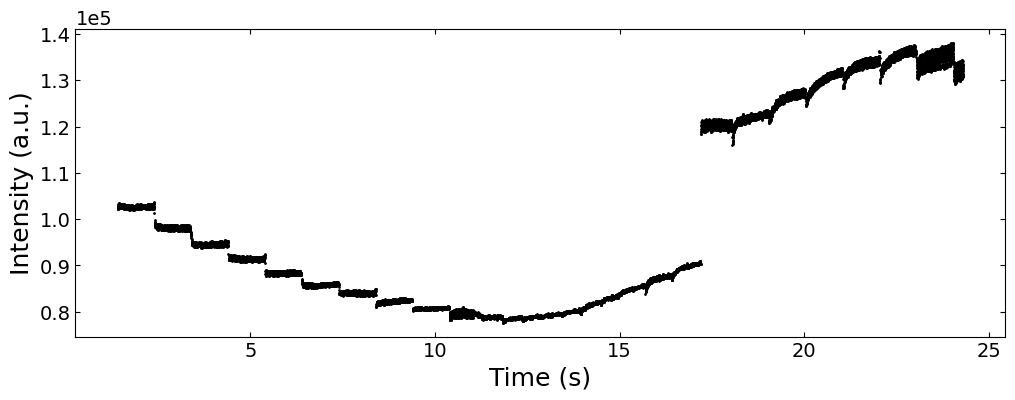

In [61]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test7_gaussian_fit_parameters_all.h5'
# title = 'Treated substrate(step width=0.43±0.04μm)'
growth_dict = {'growth_1.':1, 'growth_2':1}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=0)
x_sample = x_all[x_all<25]
y_sample = y_all[x_all<25]

x_peaks, xs, ys = detect_peaks(x_sample, y_sample, camera_freq=500, laser_freq=1, step_size=5, prominence=0.1)
xs, ys = process_rheed_data(xs, ys, length=500, savgol_window_order=(13, 3), pca_component=10)

x_sample, y_sample = np.concatenate(xs), np.concatenate(ys)
plot_curve(x_sample, y_sample, plot_type='scatter', xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,4), 
          save_path='../figures/3.Test7-First_unit_cell.png')

## 2.3 Untreated substrate(step width=0.28±0.03μm)

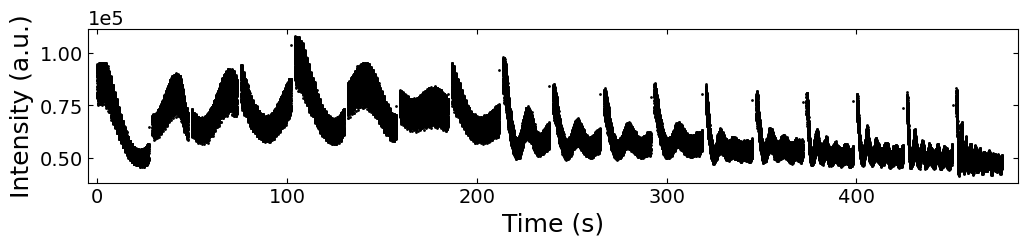

In [114]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test9_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_01':1, 'growth_02':1, 'growth_03':1, 'growth_04':1, 'growth_05':1, 
               'growth_06':1, 'growth_07':1, 'growth_08':1, 'growth_09':3, 'growth_10':3, 
               'growth_11':3, 'growth_12':3, 'growth_13':5, 'growth_14':5, 'growth_15':7, 
               'growth_16':7, 'growth_17':9, 'growth_18':15}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=1000)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2), xlim=[-5,485],
           save_path='../figures/3.sample3_intensity.png')           

In [30]:
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
def process_rheed_data(xs, ys, length=500, savgol_window_order=(15, 3), pca_component=10):    
    # interpolate the data to same size 
    if length:
        xs_processed = []
        ys_processed = []
        for x, y in zip(xs, ys):
            x_sl = np.linspace(np.min(x), np.max(x), length)
            y_sl = np.interp(x_sl, x, y)
            xs_processed.append(x_sl)
            ys_processed.append(y_sl)
    xs_processed, ys_processed = np.array(xs_processed), np.array(ys_processed)

    # denoise
    if savgol_window_order:
        ys_processed = savgol_filter(ys_processed, savgol_window_order[0], savgol_window_order[1])
    if pca_component:
        pca = PCA(n_components=pca_component)
        ys_processed = pca.inverse_transform(pca.fit_transform(ys_processed))
    return xs_processed, ys_processed

In [20]:
x_sample

array([0.0000e+00, 2.0000e-03, 4.0000e-03, ..., 4.0994e+01, 4.0996e+01,
       4.0998e+01])

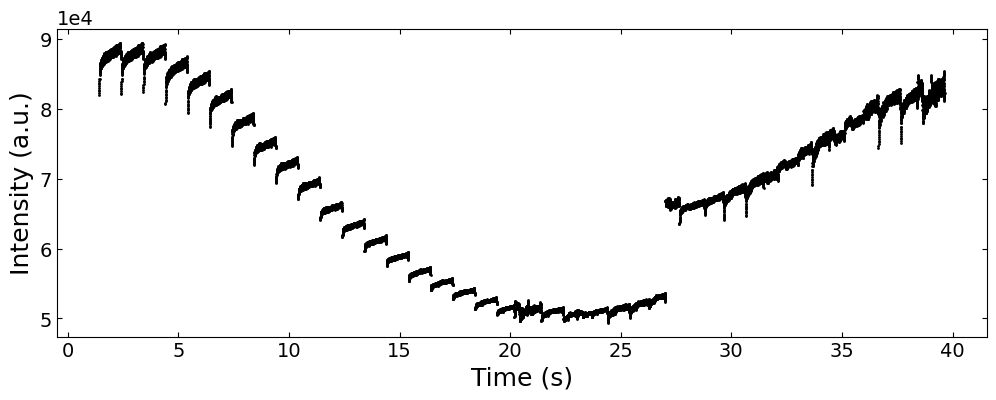

In [45]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test9_gaussian_fit_parameters_all.h5'
# title = 'Treated substrate(step width=0.43±0.04μm)'
growth_dict = {'growth_01':1, 'growth_02':1}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=0)
x_sample = x_all[x_all<41]
y_sample = y_all[x_all<41]

x_peaks, xs, ys = detect_peaks(x_sample, y_sample, camera_freq=500, laser_freq=1, step_size=5, prominence=0.1)
xs, ys = process_rheed_data(xs, ys, length=500, savgol_window_order=(19, 1), pca_component=3)

x_sample, y_sample = np.concatenate(xs), np.concatenate(ys)
plot_curve(x_sample, y_sample, plot_type='scatter', xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,4), 
          sav9e_path='../figures/3.Test9-First_unit_cell.png')

In [25]:
plot_curve(x_sample, y_sample, plot_type='scatter', xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,4), 
          save_path='../figures/3.Test9-First_unit_cell.png')

ValueError: object of too small depth for desired array